In [1]:
import numpy as np
import sys
import os
sys.path.append('../')

# Mayer-f function average for gaussian patch interaction

In [2]:
from scipy import integrate

In [3]:
#calculate the average mayer function for werthim theory
#between off-centered the patch on a particle and the centered
#patch on another particle using a lammps-style gaussian interaction
def Favg(r, rdis, A, B, rcut):  
    
    #place polymer end along the z axis
    polymer_end = np.array([0, 0, r])
    
    #interaction potential
    def SinFpp(theta, phi):
        
        patch = np.array([np.sin(theta)*np.cos(phi),
                          np.sin(theta)*np.sin(phi), 
                          np.cos(theta)])
        patch = patch*rdis
        rpp = np.linalg.norm(polymer_end - patch)
        upp = -A*np.exp(-B*rpp**2)*np.heaviside(rcut - rpp, 0)
        fpp = np.exp(-upp) - 1.0
        
        return np.sin(theta)*fpp
    
    #perform the 2D integration
    integral = integrate.dblquad(SinFpp, 0, 2.0*np.pi, lambda phi: 0, lambda phi: np.pi)
    average = integral[0] / (4.0*np.pi)
    
    return average

### Parameters

In [25]:
dp = 1.0
dc = 5.0

Amin = 0.0
Amax = 20.0
Ainc = 0.1
B = 1.0/0.2**2

rdis = dp*2.0**(1.0/6.0) + (dp + dc)/2.0 - dp
rcut = 0.5*dp
rmin = rdis - rcut*1.1
rmax = rdis + rcut*1.1

dr = 0.005
rs = np.arange(rmin, rmax, dr)
As = np.arange(Amin, Amax, Ainc)

In [26]:
path = './favg__dp={}__dc={}__B={}__rdis={}__rcut={}'.format(dp, dc, B, rdis, rcut)
if not os.path.exists(path):
    os.makedirs(path)

In [27]:
rmin, rmax

(2.572462048309373, 3.672462048309373)

### Generate, save and model the average mayer-f function

In [ ]:
for A in As:
    print "Working on A={}".format(A)
    
    data = [A]
    for r in rs:
        data.append(Favg(r, rdis, A, B, rcut))
    
    #convert to an array and save
    data = np.array(data)
    np.savetxt('{}/A={}.txt'.format(path, A), data)

### Read in the data and create ML model

In [28]:
data = []
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        data.append(np.loadtxt('{}/{}'.format(path, filename)))
    else:
        continue
data = np.array(data)

### Build analytical bond volume NN model for given interactions

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
r_scaler = StandardScaler()
A_scaler = StandardScaler()

In [31]:
rs_norm = rs[11:-10]
rs_norm = np.transpose(r_scaler.fit_transform(np.transpose(np.array([rs_norm]))))[0]

In [32]:
x_scaler = StandardScaler()
####scaler_y = StandardScaler()

In [33]:
####x_scaler = scaler_x

In [34]:
#attraction strength
x = data[:,0:1] 
x_scaler.fit(x)
x = x_scaler.transform(x)

#average mayer-f as a function of r
y = data[:,1:]
y = y[:,11:-10]
y = np.log(1.0+y)     

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [37]:
from regression.code.functional_fit_helper import FunctionalFitHelper
from keras.callbacks import ModelCheckpoint

In [38]:
# Save the checkpoint in the /output folder
filepath = "{}/model.hdf5".format(path)

In [39]:
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

In [40]:
functional_helper = FunctionalFitHelper()

In [41]:
functional_helper.InitializeNewModel(x.shape[1], num_cnts=5, 
                                     hidden_dim_rbf=200, activation_rbf='relu',
                                     hidden_dim_mod=None, activation_mod='relu')

In [42]:
model = functional_helper.BuildModel(rs_norm)

In [43]:
model.compile(loss='mean_absolute_error', optimizer='adamax')

In [44]:
# Train neural network
history = model.fit(x_train, # Features
                    y_train, # Target vector
                    epochs=10000, # Number of epochs
                    verbose=1, # No output
                    batch_size=1000, # Number of observations per batch
                    validation_data=(x_test, y_test))#,
                    #callbacks=[checkpoint]) # Data for evaluation

Train on 900 samples, validate on 100 samples
Epoch 1/10000
900/900 [==============================] - 0s - loss: 0.6495 - val_loss: 0.7072
Epoch 2/10000
900/900 [==============================] - 0s - loss: 0.6314 - val_loss: 0.6837
Epoch 3/10000
900/900 [==============================] - 0s - loss: 0.6056 - val_loss: 0.6643
Epoch 4/10000
900/900 [==============================] - 0s - loss: 0.5847 - val_loss: 0.6612
Epoch 5/10000
900/900 [==============================] - 0s - loss: 0.5807 - val_loss: 0.6694
Epoch 6/10000
900/900 [==============================] - 0s - loss: 0.5895 - val_loss: 0.6731
Epoch 7/10000
900/900 [==============================] - 0s - loss: 0.5942 - val_loss: 0.6712
Epoch 8/10000
900/900 [==============================] - 0s - loss: 0.5925 - val_loss: 0.6635
Epoch 9/10000
900/900 [==============================] - 0s - loss: 0.5843 - val_loss: 0.6589
Epoch 10/10000
900/900 [==============================] - 0s - loss: 0.5792 - val_loss: 0.6528
Epoch 11/1000

KeyboardInterrupt: 

In [63]:
model_cnts = model.get_layer('model_cnts')
model_amps = model.get_layer('model_amps')
model_efas = model.get_layer('model_efas')
model_rbfs = model.get_layer('model_rbfs')

functional_helper.InitializeOldModel(model_cnts, 
                                     model_amps, 
                                     model_efas, 
                                     model_rbfs)

In [64]:
r_new = np.arange(-2,2,0.1)
model_new = functional_helper.BuildModel(rs=r_new)

In [45]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
model_cnts (Model)               (None, 5)             3005        input_6[0][0]                    
____________________________________________________________________________________________________
model_amps (Model)               (None, 5)             3005        input_6[0][0]                    
____________________________________________________________________________________________________
model_efas (Model)               (None, 5)             3005        input_6[0][0]                    
___________________________________________________________________________________________

                                                                   model_rbfs[6][0]                 
                                                                   model_rbfs[7][0]                 
                                                                   model_rbfs[8][0]                 
                                                                   model_rbfs[9][0]                 
                                                                   model_rbfs[10][0]                
                                                                   model_rbfs[11][0]                
                                                                   model_rbfs[12][0]                
                                                                   model_rbfs[13][0]                
                                                                   model_rbfs[14][0]                
                                                                   model_rbfs[15][0]       

In [48]:
len(x_train)

900

In [24]:
len(r_new)

40

In [2821]:
model_new.compile(loss='mean_absolute_error', optimizer='adamax')

In [31]:
model.get_weights()

[array([[-0.06495678,  0.04878071, -0.06229287,  0.01801773, -0.08864701,
         -0.11663244,  0.05162846,  0.1290022 ,  0.00456085, -0.29594368,
         -0.06734412, -0.06449716,  0.05361379, -0.07428246, -0.05540209,
         -0.11643448, -0.01191875,  0.02859186,  0.11546301, -0.06929146,
          0.03590119, -0.04790652, -0.0444582 ,  0.11429727, -0.04989421,
          0.01677181,  0.14785779, -0.06178766,  0.14207432,  0.14408402,
         -0.0013206 ,  0.24026801,  0.17375076, -0.06940401, -0.01626772,
          0.00186937, -0.04905704, -0.06263739,  0.00183808,  0.05936784,
         -0.01988056,  0.11104587,  0.15243757,  0.05089238, -0.114019  ,
         -0.08696895, -0.06144009,  0.1962475 ,  0.00319031,  0.0702187 ,
         -0.04930175, -0.00689417, -0.078333  , -0.05922366,  0.07307012,
          0.05946865,  0.02707824,  0.08032963, -0.03654436,  0.17958218,
          0.24730305,  0.19816105, -0.11701823,  0.05451018,  0.04713465,
         -0.27736053,  0.0662147 , -0.

In [32]:
from keras.models import model_from_json

In [41]:
model_json = functional_helper.model_efas.to_json()

In [45]:
model_json = model.get_layer('model_rbfs').to_json()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

1.3908374939


(1e-06, 10.048999786376953)

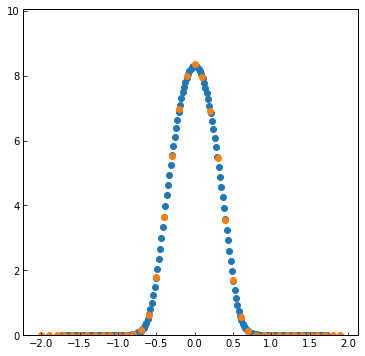

In [68]:
index = 3

xe = x[index][0]
ye = y[index]
yp = model_new.predict(np.array([[xe]]))[0]
print xe

plt.scatter(rs_norm, ye)
plt.scatter(r_new, yp)

plt.ylim(0.000001,1.2*max(yp))
#plt.ylim(0.00000001,0.0004)
#plt.yscale('log')


1.62986062485


(1e-06, 11.445930862426758)

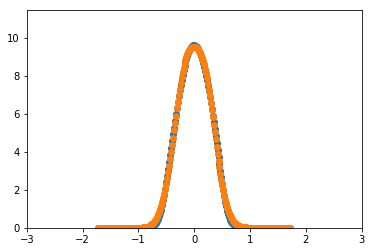

In [305]:
index = 20

xe = x_test[index][0]
ye = y_test[index]
yp = model.predict(np.array([[xe]]))[0]
print xe

#Ae = scaler_x.inverse_transform([[xe]])
#fe = np.exp(xe)*scaler_y.inverse_transform([ye])[0]
#fp = np.exp(xe)*scaler_y.inverse_transform([yp])[0]

plt.scatter(rs_norm, ye)
plt.scatter(rs_norm, yp)

plt.xlim(-3,3)
plt.ylim(0.000001,1.2*max(yp))
#plt.ylim(0.00000001,0.0004)
#plt.yscale('log')


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


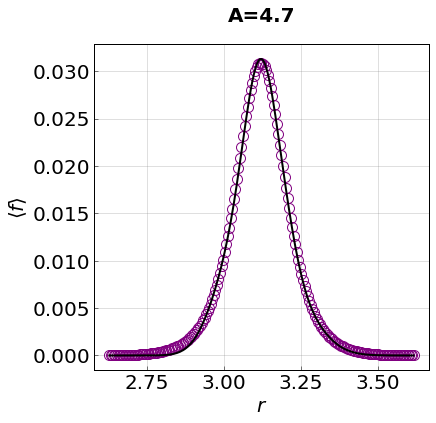

In [76]:
#SELECT TEST DATA
#index = -9
index = 6

xe = x_test[index][0]
ye = y_test[index]
yp = model.predict(np.array([[xe]]))[0]

A = x_scaler.inverse_transform([xe])[0]
r = r_scaler.inverse_transform(rs_norm)

fe = np.exp(ye)-1.0
fp = np.exp(yp)-1.0

plt.plot(r, fe, marker='o', 
         linewidth=0.0, markersize=10, color = 'purple', 
         alpha=2.0, markerfacecolor='None') 

plt.plot(r, fp, marker='o', 
         linewidth=2.0, markersize=0, color = 'black', 
         alpha=2.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0.8,0.88)

plt.xlabel(r'$r$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle f \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('A={}'.format(A), y=1.05, fontdict = title_font)

plt.show()

## Temporarily save the models to move to primary code directory

In [111]:
import dill

In [114]:
file_base = './bond_volume/model_0'

In [115]:
with open('{}/r_scaler.dill'.format(file_base), 'wb') as f:
    dill.dump(r_scaler, f)
    
with open('{}/x_scaler.dill'.format(file_base), 'wb') as f:
    dill.dump(x_scaler, f)

In [116]:
from keras.models import model_from_json

In [117]:
model_cnts = model.get_layer('model_cnts')
model_amps = model.get_layer('model_amps')
model_efas = model.get_layer('model_efas')
model_rbfs = model.get_layer('model_rbfs')

In [118]:
model_cnts_json = model_cnts.to_json()
with open('{}/model_cnts.json'.format(file_base), 'w') as json_file:
    json_file.write(model_cnts_json)
    
model_amps_json = model_amps.to_json()
with open('{}/model_amps.json'.format(file_base), 'w') as json_file:
    json_file.write(model_amps_json)
    
model_efas_json = model_efas.to_json()
with open('{}/model_efas.json'.format(file_base), 'w') as json_file:
    json_file.write(model_efas_json)  
    
model_rbfs_json = model_rbfs.to_json()
with open('{}/model_rbfs.json'.format(file_base), 'w') as json_file:
    json_file.write(model_rbfs_json)

In [119]:
model_cnts.save_weights('{}/model_cnts.h5'.format(file_base))
model_amps.save_weights('{}/model_amps.h5'.format(file_base))
model_efas.save_weights('{}/model_efas.h5'.format(file_base))
model_rbfs.save_weights('{}/model_rbfs.h5'.format(file_base))

In [120]:
r_range = np.array([rdis - rcut, rdis + rcut])
np.savetxt('{}/r_range.txt'.format(file_base), r_range)

In [121]:
A_range = np.array([Amin, Amax])
np.savetxt('{}/A_range.txt'.format(file_base), A_range)

## Special class for bond volume

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
import numpy as np
import sys
import os
sys.path.append('../')

In [4]:
from regression.code.bond_volume import BondVolume

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
bond_volume = BondVolume(model_index=0, num_rbfs=5)

/home/ryanj/Documents/research_projects/patchy_polymer_with_nanocrystal/wertheim/bond_volume/model_0


AssertionError: 

In [7]:
rs = np.arange(0.0, 9.0, 0.005)
bond_volume.InitializePredictionGrid(rs=rs)

In [8]:
_ = bond_volume.Predict(12)

/home/ryanj/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


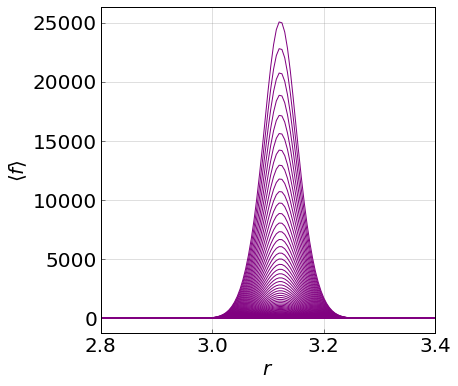

In [9]:
for A in np.arange(5.0, 20.0, 0.1):
    f = bond_volume.Predict(A)
    plt.plot(rs, f, marker='o', 
             linewidth=1.0, markersize=0, color = 'purple', 
             alpha=2.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0.8,0.88)
plt.xlim(2.8,3.4)

plt.xlabel(r'$r$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle f \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
#plt.title('A={}'.format(A), y=1.05, fontdict = title_font)

plt.show()

In [7]:
import os

In [12]:
file_base = '{}/bond_volume/model_{}'.format(os.path.abspath(__file__),2)

NameError: name '__file__' is not defined

In [11]:
print file_base

/home/ryanj/Documents/research_projects/patchy_polymer_with_nanocrystal/wertheim/bond_volume/model_2


In [13]:
os.path.realpath('bond_.py')

'/home/ryanj/Documents/research_projects/patchy_polymer_with_nanocrystal/wertheim/bond_.py'

In [20]:
import os
dn = os.path.dirname(os.path.realpath('bond_volume.py'))

In [21]:
dn

'/home/ryanj/Documents/research_projects/patchy_polymer_with_nanocrystal/wertheim'

In [18]:
regression.code.bond_volume.__file__

NameError: name 'regression' is not defined